In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model

# Body-Only Model

## X

In [4]:
df = pd.read_csv('data/processed/data_with_stem_lem.csv', index_col='Id')

In [5]:
df.fillna('code', inplace=True)

In [6]:
vocab_size = 73_747 # From 03-WordAnalysis.ipynb

token = Tokenizer(num_words=vocab_size,
                  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                  lower=True
                 )

token.fit_on_texts(df['Body'].values)
X = token.texts_to_sequences(df['Body'].values)
len(token.word_index)

114067

In [7]:
len(X)

60000

In [8]:
max_words_in_post = 300
# This number could be tweaked (look at histogram of word count per class)
padded_X = pad_sequences(X, maxlen = max_words_in_post, padding = 'post')

In [9]:
print(padded_X.shape, ' ', padded_X, sep='\n')

(60000, 300)
 
[[   6  225 2264 ...    0    0    0]
 [ 106  662    2 ...    0    0    0]
 [ 319    2  135 ...    0    0    0]
 ...
 [1749  519    1 ...    0    0    0]
 [ 492  178   86 ...    0    0    0]
 [ 744 2500  182 ...    0    0    0]]


## y

In [10]:
y = pd.get_dummies(df['Y']).values

In [11]:
print(y.shape,' ', y, sep='\n')

(60000, 3)
 
[[0 1 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 0 1]
 [0 1 0]
 [0 1 0]]


## Train Test Split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 42
                                                   )

In [14]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(48000, 300) (48000, 3)
(12000, 300) (12000, 3)


## Creating the Model

In [15]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 2,080,703
Trainable params: 2,080,703
Non-trainable params: 0
_________________________________________________________________


In [49]:
# plot_model(model, to_file='data/img/BodyOnlyModel.png',show_shapes=True)

## Training the model

In [50]:
# history = model.fit(X_train,
#                     Y_train,
#                     epochs=5,
#                     validation_split=0.1,
#                     callbacks=[EarlyStopping(monitor='val_loss',
#                                              min_delta=0.0001,
#                                              patience=3,
#                                              verbose=1,
#                                              mode='min',
#                                              )
#                               ]
#                    )

Epoch 1/5
1350/1350 [==============================] - 357s 264ms/step - loss: 1.0839 - accuracy: 0.3687 - val_loss: 0.9202 - val_accuracy: 0.5310
Epoch 2/5
1350/1350 [==============================] - 363s 269ms/step - loss: 0.8916 - accuracy: 0.5125 - val_loss: 0.9368 - val_accuracy: 0.4665
Epoch 3/5
1350/1350 [==============================] - 372s 276ms/step - loss: 0.8125 - accuracy: 0.5597 - val_loss: 0.7869 - val_accuracy: 0.5769
Epoch 4/5
1350/1350 [==============================] - 336s 249ms/step - loss: 0.7855 - accuracy: 0.5868 - val_loss: 0.7611 - val_accuracy: 0.5623
Epoch 5/5
1350/1350 [==============================] - 337s 250ms/step - loss: 0.6365 - accuracy: 0.7275 - val_loss: 0.5772 - val_accuracy: 0.7717


## Model metrics

TypeError: 'History' object is not subscriptable

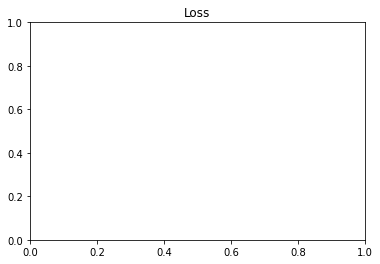

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

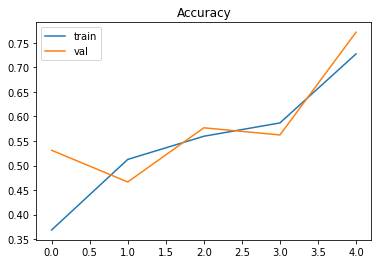

In [72]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show();

## Saving the model

In [56]:
# model.save('data/model/embedding-lstm/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: data/model/embedding-lstm/assets


## Loading the model

In [19]:
model.load_weights('data/model/embedding-lstm/variables/variables')

## Evaluation

In [20]:
evaluation = model.evaluate(X_test,Y_test)
print(f'Test set:\n\
          Loss: {evaluation[0]:0.3f}\n\
          Accuracy: {evaluation[1]:0.3f}'
     )

375/375 [==============================] - 16s 42ms/step - loss: 0.5801 - accuracy: 0.7667
Test set:
          Loss: 0.580
          Accuracy: 0.767


## Prediction

In [27]:
# HQ score = 25042, ID = 11227809
# LQ_CLOSE = -26, ID = 24681866
# LQ_EDIT = 9, ID = 3977535
hq_question = ["""Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data miraculously makes the code almost six times faster: code Without std::sort(data, data + arraySize);, the code runs in 11.54 seconds. With the sorted data, the code runs in 1.93 seconds. Initially, I thought this might be just a language or compiler anomaly, so I tried Java: code  With a similar but less extreme result. My first thought was that sorting brings the data into the cache, but then I thought how silly that was because the array was just generated. What is going on? Why is processing a sorted array faster than processing an unsorted array? The code is summing up some independent terms, so the order should not matter."""]
lq_close_question = ["""My html code is code How I convert it into wordpress menu? Actually I want include in wordpress menu title="features" data-hover="Features" """]
lq_edit_question = ["""I have two different timeseries with partially overlapping timestamps: code which represents following data: code I would like to calculate a weighted average on every day with coefficients a(0.3) and b(0.7), while ignoring missing values: code when I first try to align these timeseries: code I get correctly masked timeseries: code but when I do a1 * 0.3 + b1 * 0.7, it ignores values, that are present in one timeseries only: code What should I do to receive the awaited? code EDIT: The answer should be applicable also to more than two initial timeseries with different weights and differently missing values. o if we have four timeseries with weights T1(0.1), T2(0.2), T3(0.3) and T4(0.4), their weights at a given timestamp will be: code"""]
questions = [hq_question, lq_edit_question, lq_close_question]

for i in questions:
    sequenced = token.texts_to_sequences(i)
    padded = pad_sequences(sequenced, maxlen=max_words_in_post)
    prediction = model.predict(padded)
    labels = pd.get_dummies(df['Y']).columns
    print(prediction, labels[np.argmax(prediction)], sep='\n')

[[0.5945393  0.21653756 0.1889231 ]]
HQ
[[0.04390143 0.01957688 0.93652165]]
LQ_EDIT
[[0.25610507 0.4356904  0.30820453]]
LQ_CLOSE
